## Import

In [1]:
import wikipedia
import nltk
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

## Set user parameters

In [2]:
# PARAMETERS 
label_list=['climate','sustainability','environment']
max_num_pages=25
sentence_per_chunk=1
min_sentence_length=20

# GET STOPWORDS
# from nltk.corpus import stopwords
stop_words=nltk.corpus.stopwords.words('english')

# INITALIZE STEMMER+LEMITZIZER+SIA
sia = SentimentIntensityAnalyzer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define text cleaning function

In [3]:
def clean_string(text):
	# #FILTER OUT UNWANTED CHAR
	new_text=""
	# keep=string.printable
	keep=" abcdefghijklmnopqrstuvwxyz0123456789"
	for character in text:
		if character.lower() in keep:
			new_text+=character.lower()
		else: 
			new_text+=" "
	text=new_text
	# print(text)

	# #FILTER OUT UNWANTED WORDS
	new_text=""
	for word in nltk.tokenize.word_tokenize(text):
		if word not in nltk.corpus.stopwords.words('english'):
			#lemmatize 
			tmp=lemmatizer.lemmatize(word)
			# tmp=stemmer.stem(tmp)

			# update word if there is a change
			# if(tmp!=word): print(tmp,word)
			
			word=tmp
			if len(word)>1:
				if word in [".",",","!","?",":",";"]:
					#remove the last space
					new_text=new_text[0:-1]+word+" "
				else: #add a space
					new_text+=word.lower()+" "
	text=new_text.strip()
	return text

## Preform a wikipedia crawl

In [4]:
#INITIALIZE 
corpus=[]  # list of strings (input variables X)
targets=[] # list of targets (labels or response variables Y)

#--------------------------
# LOOP OVER TOPICS 
#--------------------------
for label in label_list:

	#SEARCH FOR RELEVANT PAGES 
	titles=wikipedia.search(label,results=max_num_pages)
	print("Pages for label =",label,":",titles)

	#LOOP OVER WIKI-PAGES
	for title in titles:
		try:
			print("	",title)
			wiki_page = wikipedia.page(title, auto_suggest=True)

			# LOOP OVER SECTIONS IN ARTICLE AND GET PAGE TEXT
			for section in wiki_page.sections:
				text=wiki_page.section(section); #print(text)

				#BREAK IN TO SENTANCES 
				sentences=nltk.tokenize.sent_tokenize(text)
				counter=0
				text_chunk=''

				#LOOP OVER SENTENCES 
				for sentence in sentences:
					if len(sentence)>min_sentence_length:
						if(counter%sentence_per_chunk==0 and counter!=0):
							# PROCESS COMPLETED CHUNK 
							
							# CLEAN STRING
							text_chunk=clean_string(text_chunk)

							# REMOVE LABEL IF IN STRING (MAKES IT TOO EASY)
							text_chunk=text_chunk.replace(label,"")
							
							# REMOVE ANY DOUBLE SPACES
							text_chunk=' '.join(text_chunk.split()).strip()

							#UPDATE CORPUS 
							corpus.append(text_chunk)

							#UPDATE TARGETS
							score=sia.polarity_scores(text_chunk)
							target=[label,score['compound']]
							targets.append(target)

							#print("TEXT\n",text_chunk,target)

							# RESET CHUNK FOR NEXT ITERATION 
							text_chunk=sentence
						else:
							text_chunk+=sentence
						#print("--------\n", sentence)
						counter+=1

		except:
			print("SOMETHING WENT WRONG:", title);  

Pages for label = climate : ['Climate', 'Climate change', 'Köppen climate classification', 'Oceanic climate', 'Subarctic climate', 'Mediterranean climate', 'Temperate climate', 'Semi-arid climate', 'Tropical climate', 'Climatize', 'Climate action', 'Humid subtropical climate', 'Tropical rainforest climate', 'Desert climate', 'Cold climate', 'Climatology', 'Climate of Saudi Arabia', 'Organisation climate', 'Climate classification', 'Climate of Antarctica', 'Climate change and agriculture', 'The Climate Fresk', 'Climate change denial', 'Continental climate', 'Humid climate']
	 Climate
	 Climate change
	 Köppen climate classification
SOMETHING WENT WRONG: Köppen climate classification
	 Oceanic climate
SOMETHING WENT WRONG: Oceanic climate
	 Subarctic climate
SOMETHING WENT WRONG: Subarctic climate
	 Mediterranean climate
	 Temperate climate
SOMETHING WENT WRONG: Temperate climate
	 Semi-arid climate
	 Tropical climate
	 Climatize
SOMETHING WENT WRONG: Climatize
	 Climate action
SOMETHING

## Save results

In [5]:
#SANITY CHECKS AND PRINT TO FILE 
print("number of text chunks = ",len(corpus))
print("number of targets = ",len(targets))

tmp=[]
for i in range(0,len(corpus)):
    tmp.append([corpus[i],targets[i][0],targets[i][1]])
df=pd.DataFrame(tmp)
df=df.rename(columns={0: "text", 1: "label", 2: "sentiment"})
print(df)
df.to_csv('wiki-crawl-results.csv',index=False)

number of text chunks =  4697
number of targets =  4697
                                                   text        label  \
0     ancient greek inclination commonly defined wea...      climate   
1     standard averaging period 30 year period may u...      climate   
2     also includes statistic average magnitude day ...      climate   
3     intergovernmental panel change ipcc 2001 gloss...      climate   
4     classical period 30 year defined world meteoro...      climate   
...                                                 ...          ...   
4692               bumptop project experimental desktop  environment   
4693  guild war narrates story displaying game cut s...  environment   
4694  enhance replayability mission often completed ...  environment   
4695  character playing mode often protected killed ...  environment   
4696  example game case eve online player often ambu...  environment   

      sentiment  
0        0.0000  
1        0.0000  
2        0.0000  
3      

In [6]:
#RELOAD FILE AND PRETEND THAT IS OUR STARTING POINT 
df=pd.read_csv('wiki-crawl-results.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; #y1=[]; y2=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
corpus=df["text"].to_list()
y2=df["sentiment"].to_numpy()

print("number of text chunks = ",len(corpus))
print(corpus[0:3])

(4697, 3)
index = 0 : label = climate
index = 1 : label = sustainability
index = 2 : label = environment
number of text chunks =  4697
['ancient greek inclination commonly defined weather averaged long period', 'standard averaging period 30 year period may used depending purpose', 'also includes statistic average magnitude day day year year variation']


## Vectorize

In [7]:
# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# DOUBLE CHECK 
print(X.shape,y1.shape,y2.shape)

(4697, 2505) (4697,) (4697,)


## Compute distance matrix

(250, 250)
[[0.         0.03779645 0.         ... 0.         0.06681531 0.        ]
 [0.03779645 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06681531 0.         0.         ... 0.         0.         0.20412415]
 [0.         0.         0.         ... 0.         0.20412415 0.        ]]


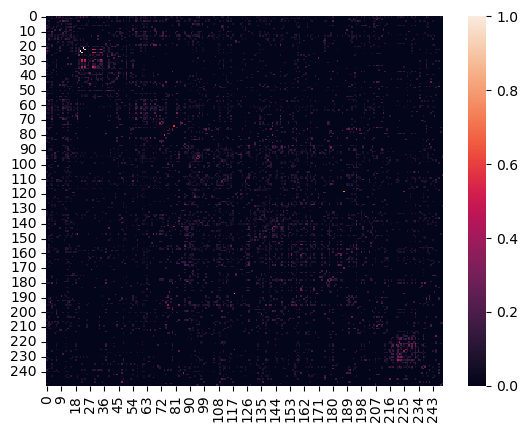

In [8]:
num_rows_keep=250
index=np.sort(np.random.choice(X.shape[0], num_rows_keep, replace=False))
# print(y1[index])
#print(index)
tmp1=X[index, :]
# print(tmp1.shape,tmp1.dtype,tmp1[:,].shape)

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]
        #print(vi.shape,vj.shape)

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) #cosine sim
        #dist=np.linalg.norm(vi-vj) #euclidean

        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2); #print(dij)
        # raise
dij=np.array(dij)

#normalize
# dij=(dij-np.min(dij))/(np.max(dij)-np.min(dij))

#Lower triangle of an array.
# dij=np.sort(dij,axis=0)
# dij=np.sort(dij,axis=1)
# dij=np.tril(dij, k=-1) 


import seaborn as sns
# sns.heatmap(np.exp(dij), annot=False) #,  linewidths=.05)
sns.heatmap(dij, annot=False) #,  linewidths=.05)
print(dij.shape)
print(dij)

## PCA

[0.01313291 0.01182663 0.00942805 0.00829692 0.00735429 0.00656916
 0.00608396 0.00590203 0.00556397 0.00521897]
[26.06216261 24.7320714  22.08212724 20.71516278 19.50294883 18.43253276
 17.73875521 17.47152043 16.96376793 16.42942223]


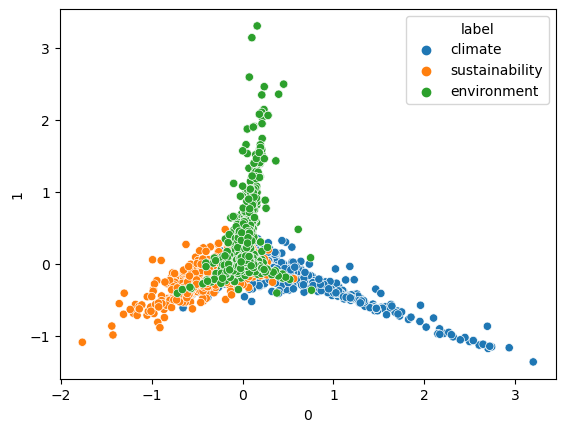

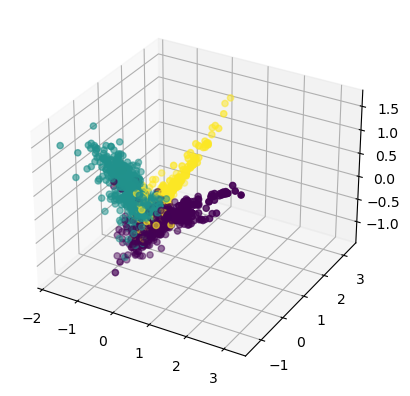

/Users/isfarbaset/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


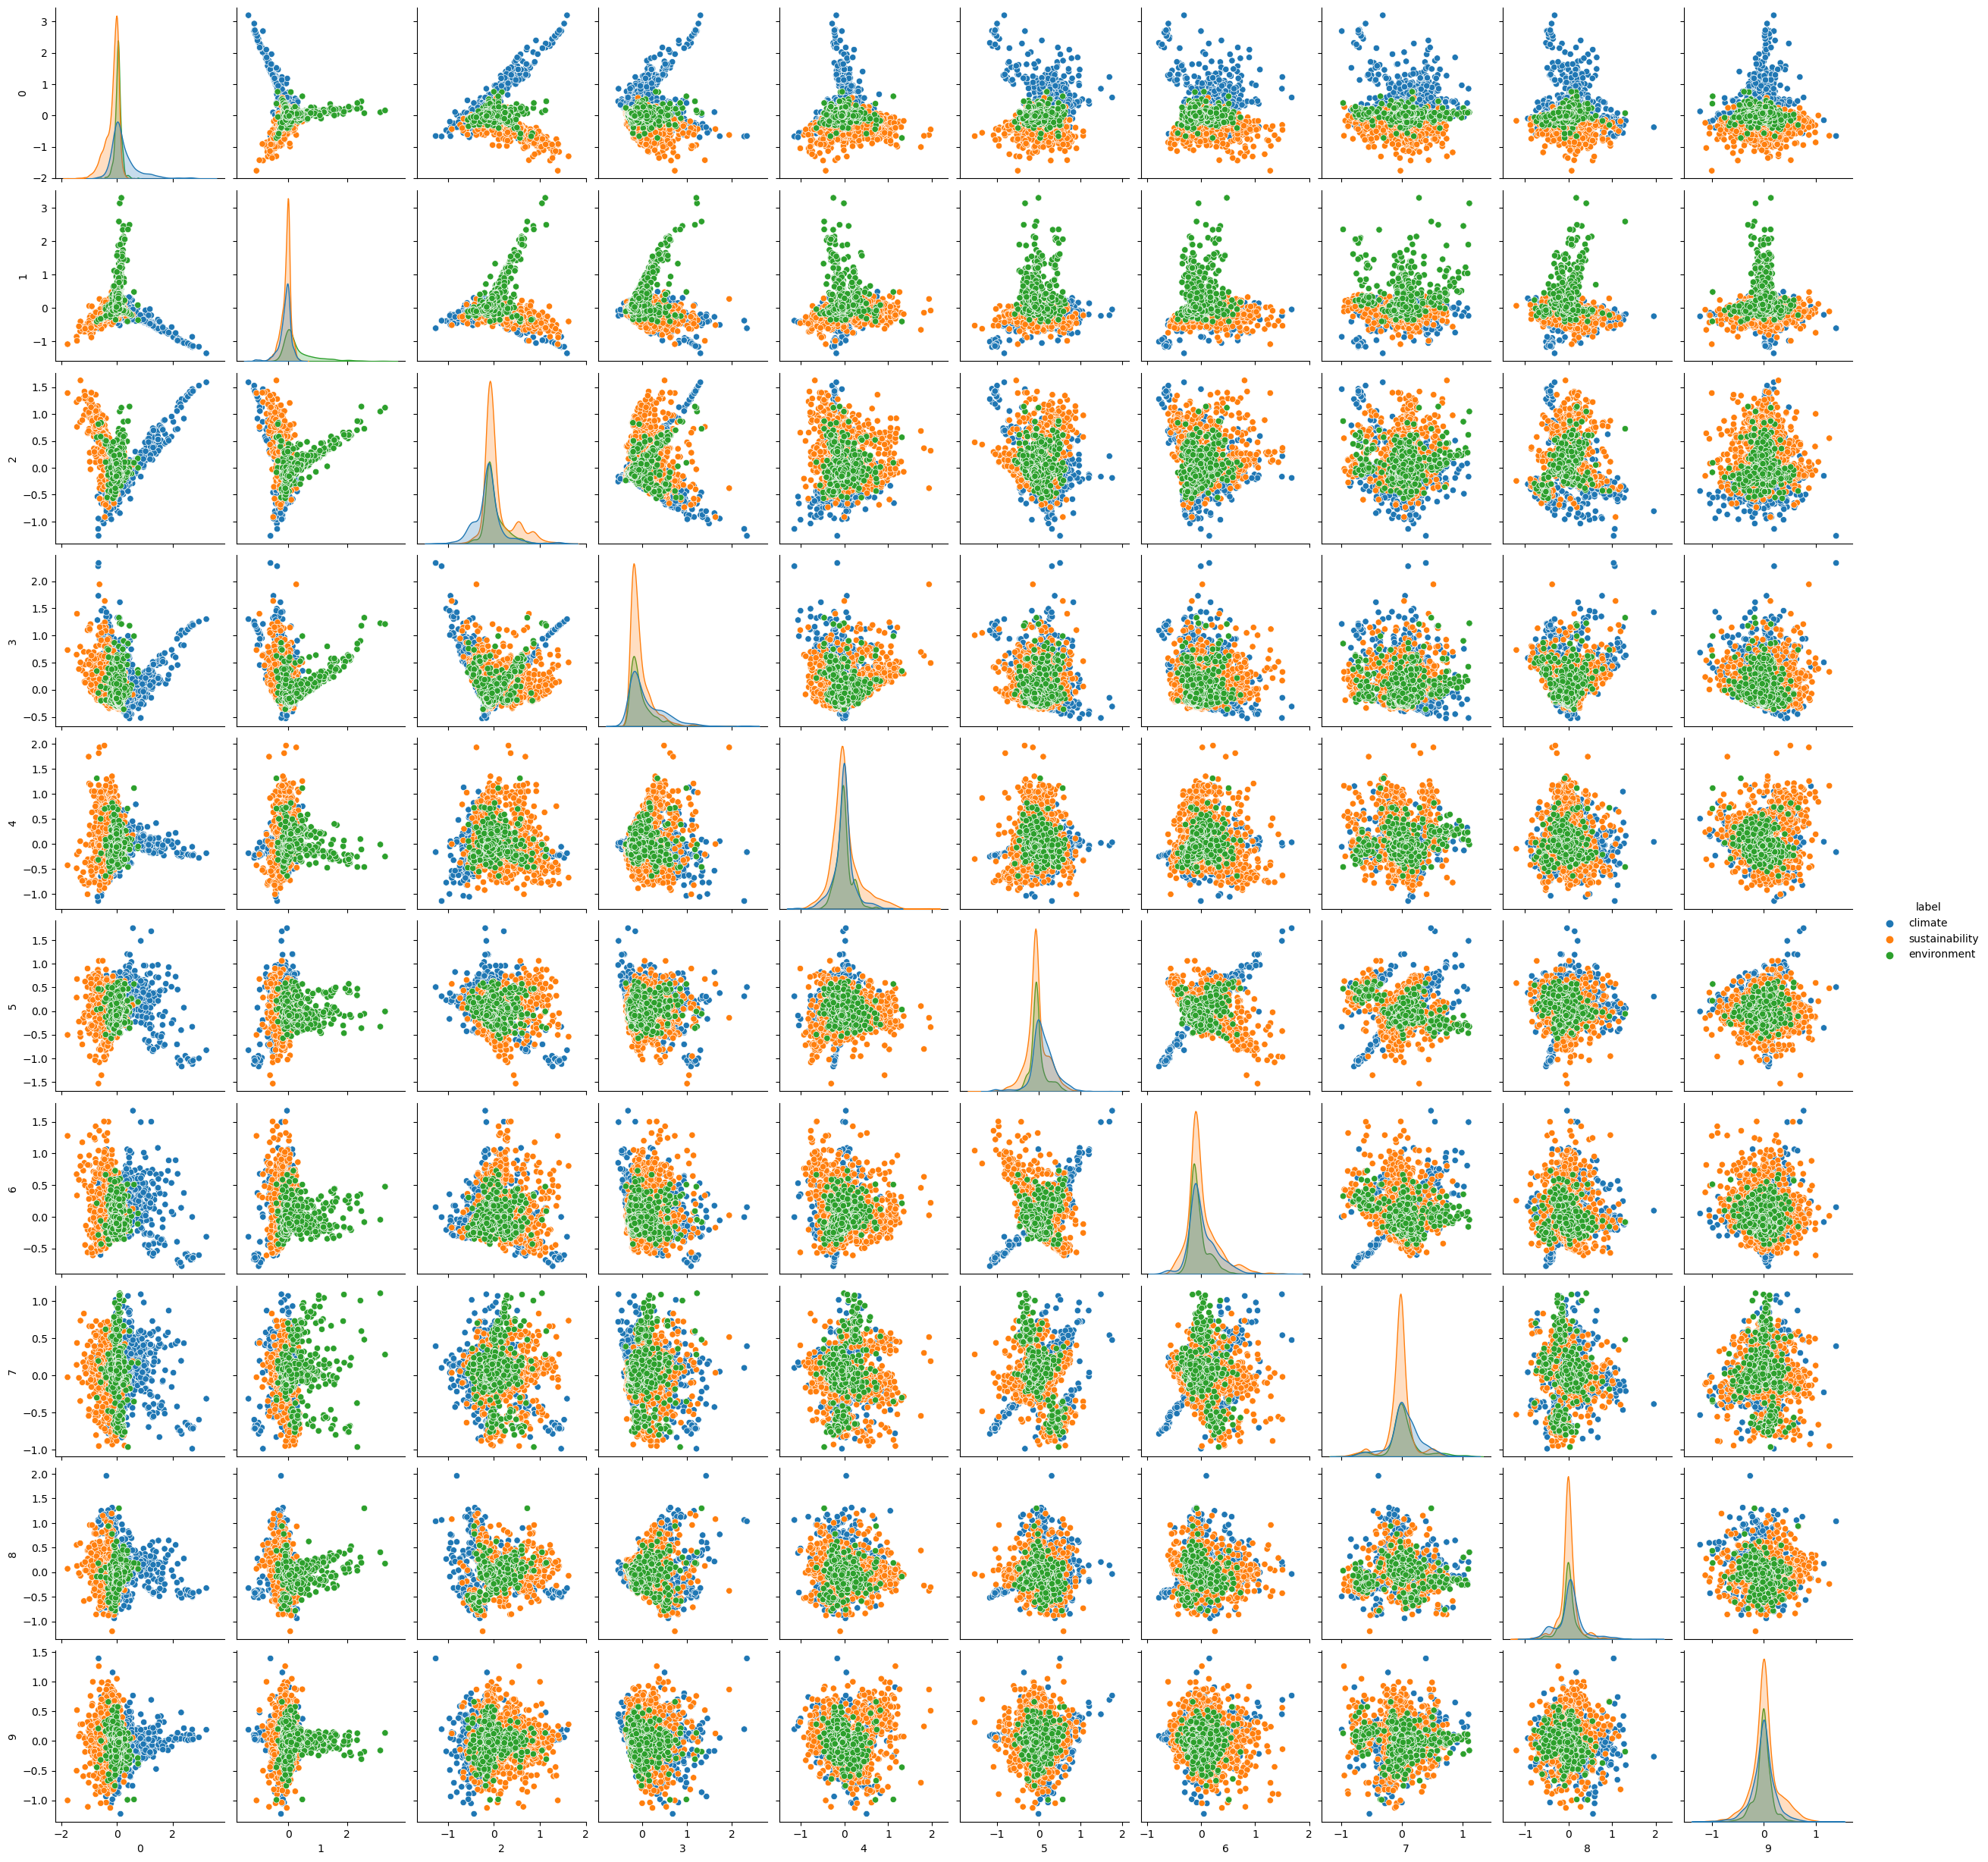

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(X)
df2 = pd.DataFrame(data = principal_components) #, columns = ['PC1','PC2','PC3','PC4','PC5'])
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
sns.pairplot(data=df3,hue="label") #.to_numpy()) #,hue=df["label"]) #, hue="time")
plt.show()